# Grover's Algorithm


If we have a database of $n$ entries and are looking for one particular entry among these, a classical computer will require $O(N)$ operations to find the entry we're looking for. A quantum computer, on the other hand, can achieve this task using only $O(\sqrt{N})$ operations. The quantum search algorithm used for this purpose is known as Grover’s algorithm, which provides a quadratic speed-up over classical search algorithms. 

In [1]:
from qiskit import *
from qiskit.compiler import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex
%matplotlib inline
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

We will start by introducing an *oracle*.

## The oracle
We wish to search through a search space of $N$ elements, and let us assume $N=2^n$ so that the index can be stored in $n$ bits. Suppose the search problem has $M$ solutions with $1\leq M \leq N$. We define a function $f$, which takes as input an integer $x$, in the range $0$ to $N-1$. By definition, $f(x) = 1$ if $x$ is a solution to the search problem, and f(x) = 0, otherwise. Suppose we have a quantum oracle, a black box,  with the ability to recognize solutions to the search problem. The oracle is a unitary operator, $O$, which may make use of an additional *oracle qubit* for recognising solutions, so that its action is defined as follows:
$$\vert x\rangle \vert q\rangle \overset{O}{\longrightarrow}\vert x\rangle \vert q\oplus f(x) \rangle,$$ where $\vert x\rangle$ is the index register and the oracle qubit $\vert q\rangle$ is a single qubit which is flipped if $f(x) = 1$, and is unchanged otherwise. It is convenient to initially set the oracle qubit to $(\vert 0\rangle-\vert 1\rangle)/\sqrt{2}$ since the action of the oracle becomes:
$$\vert x\rangle \left(\frac{\vert 0\rangle-\vert 1\rangle}{\sqrt2}\right) \overset{O}{\longrightarrow}(-1)^{f(x)}\vert x\rangle\left(\frac{\vert 0\rangle-\vert 1\rangle}{\sqrt2}\right) $$
Since the oracle qubit remains the same effectively, the action of the oracle may be written as:
$$\vert x\rangle \overset{O}{\longrightarrow}(-1)^{f(x)}\vert x\rangle.$$
The quantum search algorithm begins with the computer in the state $\vert 0\rangle^{\otimes n}$. The Hadamard transform is used to put the computer in the equal superposition state,
$$\vert \psi\rangle=\frac{1}{\sqrt{N}}\sum\limits_{x=0}^{N-1} \vert x\rangle$$

Now let's utilise Qiskit to help design some of these mysterious oracles for a few simple cases.

Suppose we have $N$=4 and only one of the four states happens to be the sought after solution. Let the solution state be denoted by $\vert w\rangle$.

We will first see what the oracle looks like in case $\vert w\rangle = \vert 11\rangle$. 

The way the oracle $O$ is expected to behave is as follows: $$O \frac{1}{2}(\vert 00\rangle +\vert 01\rangle +\vert 10\rangle +\vert 11\rangle)=\frac{1}{2}(\vert 00\rangle +\vert 01\rangle +\vert 10\rangle -\vert 11\rangle)$$

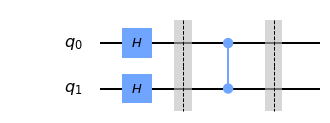

In [2]:
qc1=QuantumCircuit(2)
qc1.h(0)
qc1.h(1)
qc1.barrier() #The part between the barriers is our oracle
qc1.cz(0,1)
#We are using a controlled-Z gate which flips the sign of the second qubit when both qubits are set to '1'
qc1.barrier()
qc1.draw('mpl')

In [3]:
def final_vector(qc):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    outputstate = result.get_statevector(qc, decimals=3)
    return outputstate
print(final_vector(qc1)) #We can see that the desired state has been obtained


[ 0.5+0.j  0.5+0.j  0.5+0.j -0.5+0.j]


## Your Task
1) Make an oracle for $N=8$ and $\vert w \rangle=\vert 010 \rangle$, and run it as done above.

**(3 points)**

**Solution:**

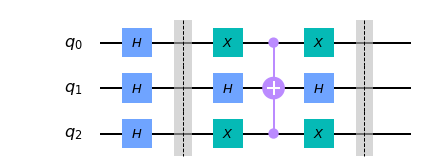

In [4]:
qc2=QuantumCircuit(3)

qc2.h(0)
qc2.h(1)
qc2.h(2)
qc2.barrier() 
#The part between the barriers is our oracle
qc2.x(0)
qc2.x(2)

#We are just using the ccz gate which we have defined later
qc2.h(1)
qc2.ccx(0,2,1)
qc2.h(1)

qc2.x(2)
qc2.x(0)

qc2.barrier()
qc2.draw('mpl')

In [5]:
#print the final vector
print(final_vector(qc2))
#The negative sign has been applied only to |010> in the equal superposition of states

[ 0.354-0.j  0.354+0.j -0.354+0.j  0.354-0.j  0.354+0.j  0.354+0.j
  0.354-0.j  0.354-0.j]


## The Grover iteration

The Grover iteration or Grover operator, denoted by $G$, consists of the following four steps, and it is applied repeatedly throughout the search algorithm.

1) Apply the oracle $O$.

2) Apply the Hadamard transform $H^{\otimes n}$.

3) Perform a conditional phase shift on the computer, with every computational basis state except $\vert 0\rangle$ receiving a phase shift of -1,
$$\vert x\rangle\longrightarrow -(-1)^{\delta_{x0}}\vert x\rangle.$$ 

4) Apply the Hadamard transform $H^{\otimes n}$.

The combined effect of steps 2, 3, and 4 is
$$H^{\otimes n}(2\vert 0\rangle\langle 0\vert -I) H^{\otimes n}=2\vert \psi\rangle\langle \psi\vert -I,$$ where $\vert \psi\rangle$is the equally weighted superposition of states.

Thus the Grover iteration may be written as
$$G=(2\vert \psi\rangle\langle \psi\vert -I)O.$$

The following is the circuit for Grover iteration, $G$:

<img src="https://raw.githubusercontent.com/mnp-club/Quantum_Computing_Workshop_2020/master/images/grover.jpg" width = "600" height = "400"></img>

### Geometric visualisation

Let $\sideset{}{'}\sum\limits_x $ indicate a sum over all $x$ which are solutions to the search problem and $\sideset{}{''}\sum\limits_x$ indicate a sum over all x which are not solutions to the search problem. We define normalized states
$$\vert\alpha\rangle=\frac{1}{\sqrt{N-M}}\sideset{}{''}\sum\limits_x \vert x\rangle$$
$$\vert\beta\rangle=\frac{1}{\sqrt{M}}\sideset{}{'}\sum\limits_x\vert x\rangle$$
So, the initial state can be expressed as 
$$\vert\psi\rangle=\sqrt{\frac{N-M}{N}}\vert\alpha\rangle+\sqrt{\frac{M}{N}}\vert\beta\rangle.$$
The oracle operation $O$ performs a reflection about the vector $\vert\alpha\rangle$ in the plane defined by $\vert\alpha\rangle$ and $\vert\beta\rangle$. That is, $$O(a\vert\alpha\rangle + b\vert\beta\rangle)=a\vert\alpha\rangle-b\vert\beta\rangle.$$ Similarly, $2\vert \psi\rangle\langle \psi\vert -I$ also performs a reflection in the plane defined by $\vert\alpha\rangle$ and $\vert\beta\rangle$, about the vector $\vert\psi\rangle$. (To understand this, consider any unit vector $\vert\phi_1\rangle$ parallel to $\vert\psi\rangle$, on applying this operation, it remains the same, while any vector $\vert\phi_2\rangle$ perpendicular to $\vert\psi\rangle$ gets its sign flipped.)

The product of two reflections is a rotation. 
Let $\cos(\theta/2)=\sqrt{(N-M)/N}$, so that $$\vert\psi\rangle = \cos(\theta/2)\vert\alpha\rangle+ \sin(\theta/2)\vert\beta\rangle.$$ 
The two reﬂections which comprise $G$ take $\vert\psi\rangle$ to 
$$G\vert\psi\rangle = \cos\left(\frac{3\theta}{2}\right)\vert\alpha\rangle+ \sin\left(\frac{3\theta}{2}\right)\vert\beta\rangle,$$
so the rotation angle of operator $G$ in the space spanned by $\vert\alpha\rangle$ and $\vert\beta\rangle$ is $\theta$. 

The following figure shows the action of a single Grover iteration, $G$.
<img src="https://raw.githubusercontent.com/mnp-club/Quantum_Computing_Workshop_2020/master/images/geometrygrover.jpg" width = "300" height = "300"></img>

Continued application of $G$ takes the state to 
$$G^k\vert\psi\rangle = \cos\left(\frac{2k+1}{2}\theta\right)\vert\alpha\rangle+ \sin\left(\frac{2k+1}{2}\theta\right)\vert\beta\rangle.$$
Repeated application of the Grover iteration rotates the state vector close to $\vert\beta\rangle$! Since $\vert\beta\rangle$ is the superposition of all the solution states, getting as close as we can to $\vert\beta\rangle$ is what we aim to achieve.

## Quantum search algorithm and its performance
Rotating through $\arccos(\sqrt{M/N})$ radians takes the system to $\vert\beta\rangle$.Let CI($x$) denote the integer closest to the real number $x$, where by convention we round halves down, CI(3.5)=3, for example. Then repeating the Grover iteration 
$$R=CI\frac{\arccos\sqrt{M/N}}{\theta},$$
times rotates $\vert\psi\rangle$ to within an angle $\theta/2 \leq \pi/4$ of $\vert\beta\rangle$. Observing the state then yields a solution to the search problem with probability at least 1/2.\\
 Assuming for the moment that $M \leq N/2$, we have 
 $$\frac{\theta}{2}\geq\sin\left(\frac{\theta}{2}\right)=\sqrt{\frac{M}{N}}$$
 Since $R\leq\lceil\pi/2\theta\rceil$, so we obtain an upper bound on the number of iterations required
 $$R\leq\left\lceil\frac{\pi}{4}\sqrt{\frac{N}{M}}\right\rceil$$
Thus $R=O\sqrt{N/M})$ Grover iterations (and thus oracle calls) must be performed in order to obtain a solution to the search problem with high probability. 


## Algorithm: Quantum search (summarized for the case $M = 1$)
### Inputs:
**1.** A black box oracle $O$ which performs the transformation $O\vert x\rangle\vert q\rangle=\vert x\rangle\vert q\oplus f(x)\rangle$ where $f(x) = 0$ for all $0 \leq x\leq 2^n$ except $x_0$, for which $f(x_0) = 1$

**2.** $n +1$ qubits in the state $\vert 0\rangle$. 

### Outputs:
$x_0$.

### Runtime:
$O(\sqrt{2^n})$ operations. Succeeds with probability $O(1)$. 

### Procedure:

**1.** $\vert 0\rangle^{\otimes n}\vert 0\rangle$   

*initial state*

**2.** $\displaystyle{\longrightarrow \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}\vert x\rangle\left[\frac{\vert 0\rangle-\vert 1\rangle}{\sqrt{2}}\right]}$   

*apply $H^{\otimes n}$ to the first $n$ qubits, and $HX$ to the last qubit*

**3.**$\displaystyle{\longrightarrow [(2\vert \psi\rangle\langle \psi\vert -I)O]^R \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}\vert x\rangle\left[\frac{\vert 0\rangle-\vert 1\rangle}{\sqrt{2}}\right]}$   
$\displaystyle{\approx \vert x_0\rangle\left[\frac{\vert 0\rangle-\vert 1\rangle}{\sqrt{2}}\right]}$ 
 
 *apply the Grover iteration $R\approx[\pi \sqrt{2^n}/4]$times*

**4.**$\longrightarrow x_0$    

*measure the first $n$ qubits*



From the expression $\theta = \arcsin\left(\frac{2\sqrt{M(N-M)}}{N}\right)$, we see that the angle $\theta$ gets smaller as $M$ varies from $N/2$ to $N$, hence increasing the number of iterations needed by the search algorithm with M, for $M \geq N/2$, which is counter-intuitive.

One way of solving this problem is if $M$ is known in advance to be larger than $N/2$ then we can just randomly pick an item from the search space and check if it is a solution using the oracle. This approach has a success probability at least one-half, and only requires one consultation with the oracle.

In the case where it isn't known whether $M \geq N/2$, the approach is to double the number of elements in the search space by adding a single qubit $\vert q\rangle$ to the search index which adds $N$ extra items to the search space, none of which are solutions. So, less than half the items in the new search space are solutions. A new augmented oracle $O'$ is constructed. using one call to $O$, which marks an item only if it is a solution to the search problem **and** the extra bit is set to zero. At most $R = \pi/4\sqrt{2N/M}$ calls to $O'$ are required, and it follows that $O(\sqrt{N/M})$ calls to $O$ are required to perform the search.

## Implementation using Qiskit
We will now go through the example of Grover's algorithm for 3 qubits with two solution states $\vert 101\rangle$  and $\vert 110\rangle$. So here, we have $M=2$ and $N=8$.

Observe that in this case the above-defined state $\vert \psi\rangle$ will make an angle $\theta/2=\arccos\left(\sqrt{\frac{8-2}{8}}\right)=\pi/6$ with the $\vert\alpha\rangle$ axis, and an angle $\pi/3$ with the $\vert\beta\rangle$ axis, which in this case happens to be $\theta$, so one Grover iteration will give us the solutions states! This is portrayed below.

In [6]:
def ccz_gate(qc,a,b,c):
    qc.h(c)
    qc.ccx(a,b,c)
    qc.h(c)
    
    

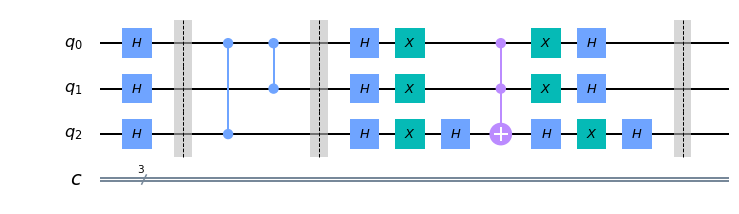

In [7]:
#Let's create an oracle which will mark the states 101 and 110
#(This particular oracle won't be using ancilla qubits)
def phase_oracle(circuit):
    circuit.cz(0, 2)
    circuit.cz(0, 1)
n=3
qc2=QuantumCircuit(n,n)
for i in range(0,n):
    qc2.h(i)
qc2.barrier([0,1,2])
#This creates a superposition of all states

#We will now perform the Grover iteration
phase_oracle(qc2)
qc2.barrier([0,1,2])
for i in range(0,n):
    qc2.h(i)
    
#Performing a conditional phase shift
qc2.x(0)
qc2.x(1)
qc2.x(2)
ccz_gate(qc2,0,1,2)
qc2.x(0)
qc2.x(1)
qc2.x(2)
for i in range(0,n):
    qc2.h(i)
#The Grover iteration is now complete

qc2.barrier([0,1,2])
qc2.draw('mpl')


To verify our above reasoning of obtaining the solution states $\vert 101\rangle$  and $\vert 110\rangle$ after applying the above circuit, let us measure the qubits.

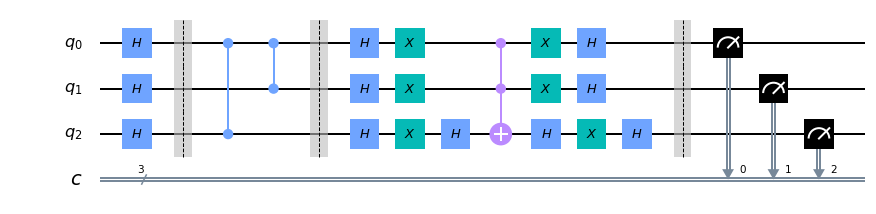

In [8]:
qc2.measure(0,0)
qc2.measure(1,1)
qc2.measure(2,2)
qc2.draw('mpl')

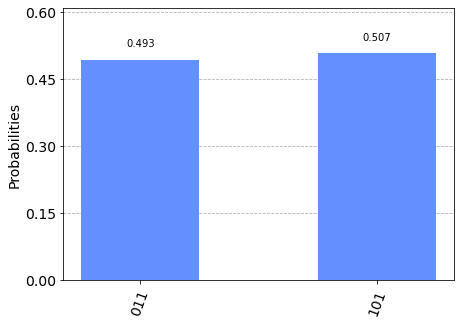

In [9]:
def counts_circ(circ):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=2000)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    return(counts)
plot_histogram(counts_circ(qc2))


As you can see, we have succeeded in obtaining the solution states!


## Multiple-Control Toffoli gate
Before we give you your next task on Grover's algorithm, we would like to introduce the very useful Multiple-Control Toffoli gate, denoted by **MCT** in Qiskit. The control qubits are specified in the form of a list as the first argument in the **mct** function, while the target qubit is entered as the second argument.

Let us implement it and see what it does.


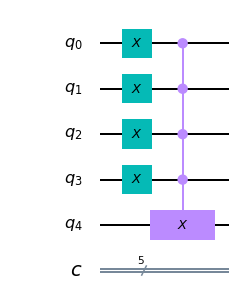

In [10]:
qc_mct=QuantumCircuit(5,5)
for i in range(0,4):
    qc_mct.x(i)
qc_mct.mct([0,1,2,3],4)
qc_mct.draw('mpl')

This is what a multi-control Toffoli gate looks like. It reverses the target qubit if and only if all the control qubits are set to '1'. In the above example the MCT gate is applied to the state $\vert 11110\rangle$. Run the following cell to see the obtained state upon measurement.

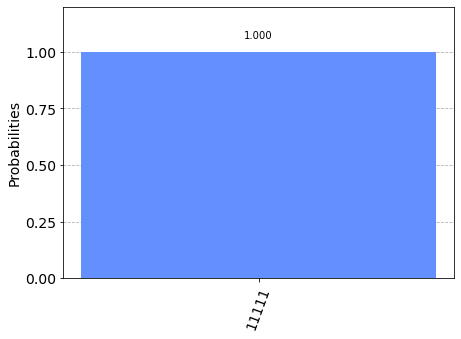

In [11]:
qc_mct.measure(0,0)
qc_mct.measure(1,1)
qc_mct.measure(2,2)
qc_mct.measure(3,3)
qc_mct.measure(4,4)
plot_histogram(counts_circ(qc_mct))

## Your Task
2) Construct a circuit to carry out the Grover's algorithm for 4 qubits with these solution states: $\vert 1010\rangle, \vert 0010\rangle, \vert 1001\rangle$ and $\vert 1000\rangle$.

You are free to use any of the functions defined above. You are required to display both the circuit and the histogram showing the end-result.

**(5 points)**

**Solution:**
Here, $M=4$ and $N=2^4=16$.

So, $\theta/2=\arcsin({\sqrt{M/N}})=\arcsin({1/2})=\pi/6$.
Therefore, one Grover iteration will result in a rotation of $\theta=\pi/3$, hence exactly obtaining state $\vert \beta \rangle$.

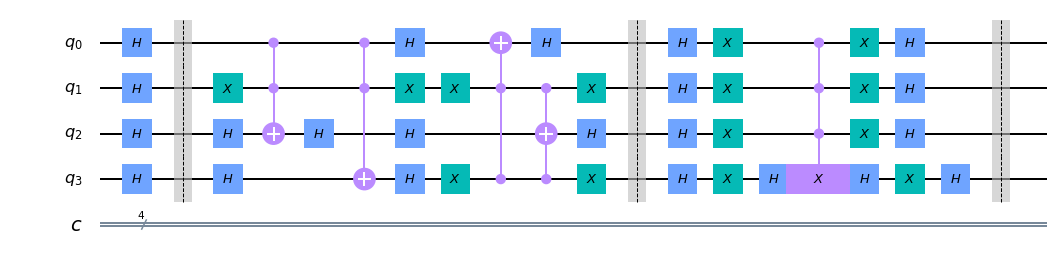

In [12]:
def cccz_gate(qc,a,b,c,d):
    #Suppose qubit d is the target qubit
    qc.h(d)
    qc.mct([a,b,c],d)
    qc.h(d)

#Let's now define the operation for the conditional phase shift (i.e., on |0000>)
def zero_oracle(qc):
    qc.x([0,1,2,3])
    cccz_gate(qc,0,1,2,3)
    qc.x([0,1,2,3])



n=4
qc3=QuantumCircuit(n,n)
for i in range(0,n):
    qc3.h(i)
qc3.barrier([0,1,2,3])

#Finally the oracle for marking the solution states

qc3.x(1)
ccz_gate(qc3,0,1,2)
ccz_gate(qc3,0,1,3)
qc3.x(1)
#The above portion just marked states '1001' and '1010'

qc3.x(1) 
qc3.x(3) 
ccz_gate(qc3,1,3,0)
ccz_gate(qc3,1,3,2)
qc3.x(3) 
qc3.x(1)
#This portion marked states '1000' and '0010'
#The oracle ends


qc3.barrier([0,1,2,3])
for i in range(0,n):
    qc3.h(i)

zero_oracle(qc3)

for i in range(0,n):
    qc3.h(i)
#The Grover iteration is now complete

qc3.barrier([0,1,2,3])
qc3.draw('mpl')   

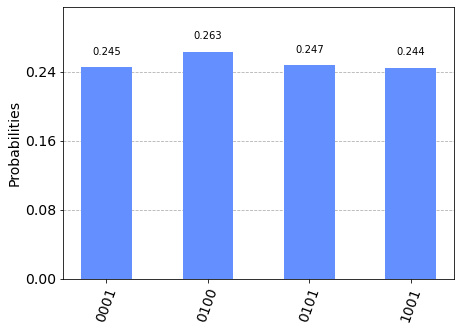

In [13]:
qc3.measure([0,1,2,3],[0,1,2,3])
plot_histogram(counts_circ(qc3))

We have successfully obtained the required solution states!